### Import libraries

In [1]:
import time
import numpy as np
from numpy import matlib
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

### Display utility functions

In [2]:
def NewFigure(sizeCol=12, sizeRow=6):
    return plt.figure(figsize=(sizeCol, sizeRow))

def DisplaySub(fig, countRow,countCol,index,image,title='',
               axis='off',cmap=None):
    ax=fig.add_subplot(countRow, countCol, index)
    plt.title(title)
    plt.axis(axis)
    plt.imshow(image,cmap=cmap)
    return ax

### Define calibration target

In [3]:
nx, ny = 9, 6
# prepare object points, 
# like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

### Load and display calibration images

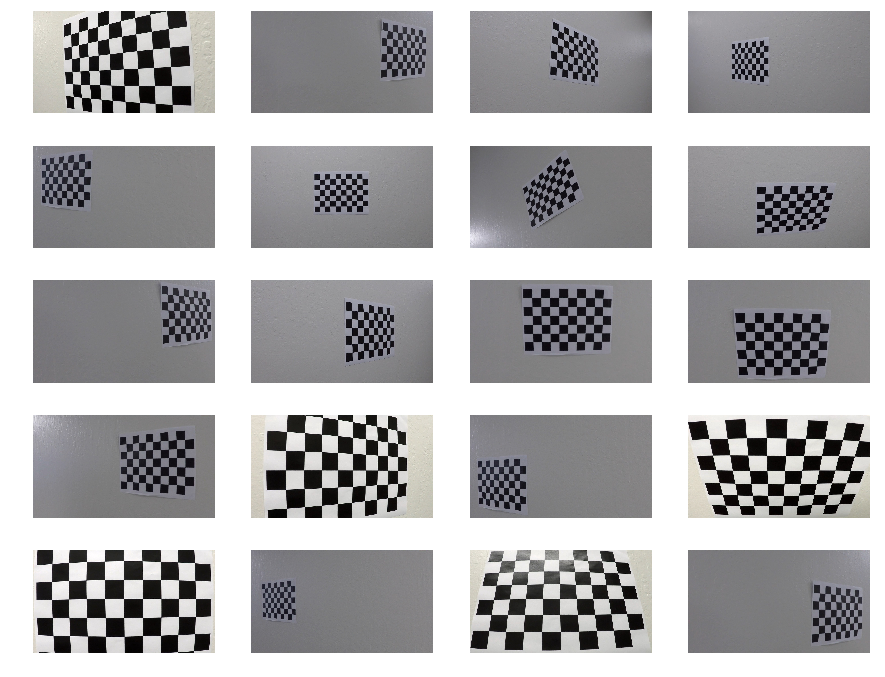

In [4]:
# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

f = NewFigure(15, 12)
rows = 5
columns = 4
for i,fname in enumerate(images):
    img=mpimg.imread(fname)
    ax=DisplaySub(f, rows,columns,i+1,img,title='',
                  cmap=None)

### Detect calibration targets

In [5]:
# Arrays to store object points and image points 
# from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

found = np.zeros((len(images)),dtype=np.int)
calib_images=[]

for i,fname in enumerate(images):
    img=mpimg.imread(fname)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, 
                                             (nx,ny), 
                                             None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        found[i]=1

        # Draw and display the corners
        cv2.drawChessboardCorners(img, 
                                  (nx,ny), 
                                  corners, 
                                  ret)
    calib_images.append(img)

### Display successful detected targets

Number of calibration target detected: 17/20


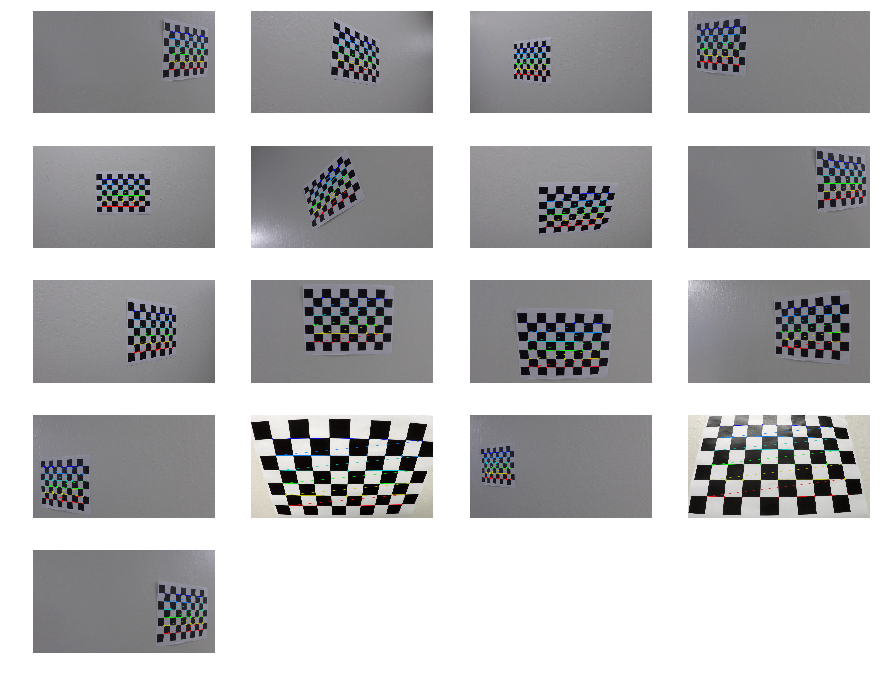

In [6]:
found_indices=np.argwhere(found==1).reshape(-1).tolist()
print("Number of calibration target detected: %d/%d"
      %(len(found_indices),len(images)))
f = NewFigure(15, 12)

n=len(found_indices)
columns=4
rows=np.ceil(n/columns)
count=0
for i in found_indices:
    DisplaySub(f, rows,columns,count+1,calib_images[i],
               cmap=None)
    count+=1

### Display failed detected targets

Indices of failed detection:
[0, 13, 16]


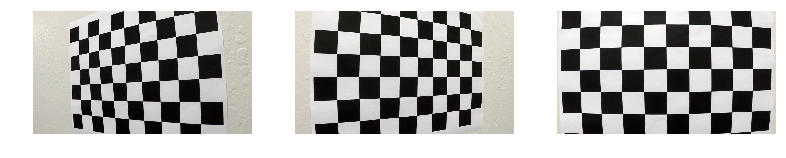

In [7]:
failed_indices=np.argwhere(found==0).reshape(-1).tolist()
print("Indices of failed detection:")
print(failed_indices)

f = NewFigure(18, 14)

n=len(failed_indices)
columns=4
rows=np.ceil(n/columns)
count=0
for i in failed_indices:
    DisplaySub(f, rows,columns,count+1,calib_images[i],
               cmap=None)
    count+=1

### Calibrate camera

In [8]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                   imgpoints, 
                                                   img.shape[1::-1],
                                                   None,
                                                   None)

### Undistort and wrap calibration image

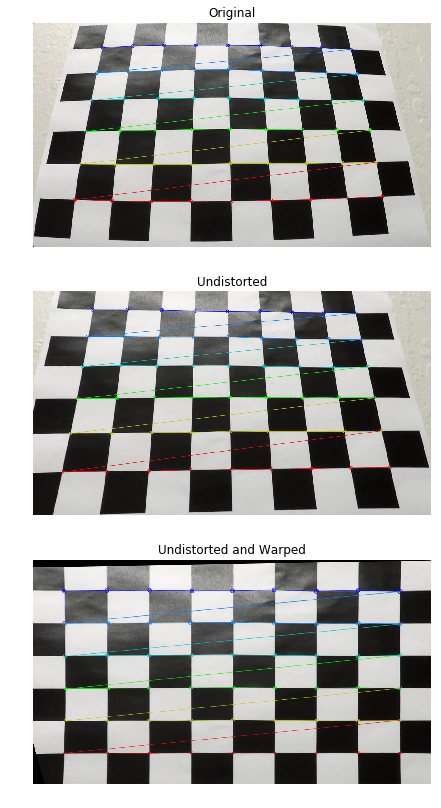

In [9]:
index=18
offset =100
img = cv2.imread(images[index])
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_size=img.shape[1::-1]

undist = cv2.undistort(img, mtx, dist)
gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, 
                                         (nx, ny), 
                                         None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
    src = np.float32([corners[0], corners[nx-1], 
                      corners[-1], corners[-nx]])
    dst = np.float32([[offset, offset], 
                      [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(undist, M, 
                                 undist.shape[1::-1], 
                                 flags=cv2.INTER_LINEAR)

f=NewFigure(35,14)
ax1=DisplaySub(f,3,1,1,calib_images[index],title='Original')
ax1=DisplaySub(f,3,1,2,undist,title='Undistorted')
ax2=DisplaySub(f,3,1,3,warped,title='Undistorted and Warped',
               cmap='gray')

### Display static frame of video and region of interest (ROI)

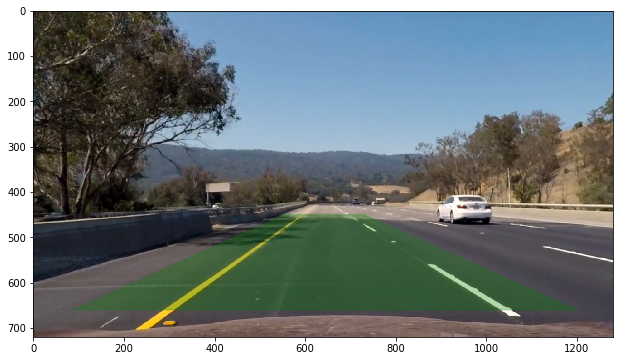

In [10]:
# Read image and undistort image
image=cv2.imread('test_images/debug.png')
#image=cv2.imread('test_images/test3.jpg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
undist = cv2.undistort(image, mtx, dist)

# Define ROI
verticesX=[90,555,730,1200]
verticesY=[660,450,450,660]
vertices=np.zeros((1,len(verticesX),2), dtype=np.int32)
for i in range(len(verticesX)):
    vertices[0,i,0]=verticesX[i]
    vertices[0,i,1]=verticesY[i]

# Display undistorted image and ROI
roi=Polygon(vertices[0,:,:],closed=True,color='g',alpha=0.3)
f=NewFigure()
ax=DisplaySub(f,1,1,1,undist,title='',axis='on',cmap='gray')
ax.add_patch(roi)
plt.show()

### Parameters of lane detection pipeline

In [11]:
sobel_kernel = 3
sobelx_thresh = 30
saturation_thresh = 80
hue_thresh = 50
closing_kernel = 7 
min_area = 40
min_elongation = 2.0
min_minorlength = 4.0

### Functions for segmentation

In [12]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, 
                     thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if (orient=='x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, 
                          ksize=sobel_kernel)
    elif (orient=='y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, 
                          ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel,dtype=np.uint8)
    grad_binary[(scaled_sobel > thresh[0]) 
                & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def color_thresh(img, hthresh=(0, 255), sthresh=(0, 255)):
    # Convert to HLS color space
    # Apply threshold
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    # Threshold color channel
    h_binary = np.zeros_like(h_channel,dtype=np.uint8)
    h_binary[(h_channel > hthresh[0]) 
             & (h_channel <= hthresh[1])] = 1
    s_binary = np.zeros_like(s_channel,dtype=np.uint8)
    s_binary[(s_channel > sthresh[0]) 
             & (s_channel <= sthresh[1])] = 1
    binary = h_binary & s_binary
    return binary

def region_of_interest(img, vertices):
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill 
    # the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined 
    # by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Output of segmentation for full image

Elapsed time = 0.016662 sec
Elapsed time = 0.017005 sec


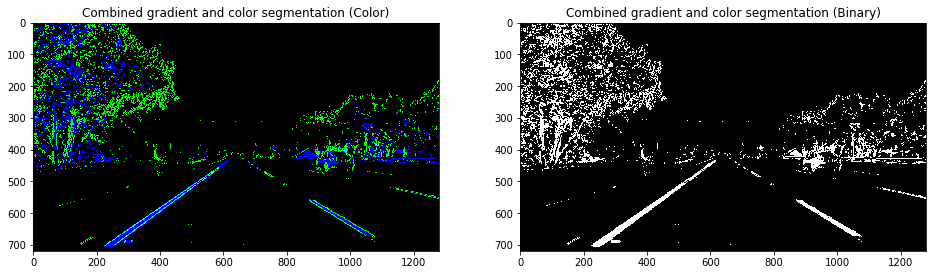

In [13]:
last_time = time.time()
gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=sobel_kernel, thresh=(sobelx_thresh, 255))
timeElapsed=time.time()-last_time
print("Elapsed time = %.6f sec"%(timeElapsed))

last_time = time.time()
saturation = color_thresh(undist,hthresh=(0, hue_thresh),sthresh=(saturation_thresh, 255))
timeElapsed=time.time()-last_time
print("Elapsed time = %.6f sec"%(timeElapsed))

combined_color = np.dstack(( np.zeros_like(gradx), gradx, saturation)) * 255
combined_binary = np.zeros_like(gradx)
combined_binary[((gradx == 1) | (saturation == 1))] = 1
f=NewFigure(16,20)
ax1=DisplaySub(f,1,2,1,combined_color,title='Combined gradient and color segmentation (Color)', axis='on')
ax2=DisplaySub(f,1,2,2,combined_binary,title='Combined gradient and color segmentation (Binary)',axis='on',cmap='gray')

### Cropping of ROI

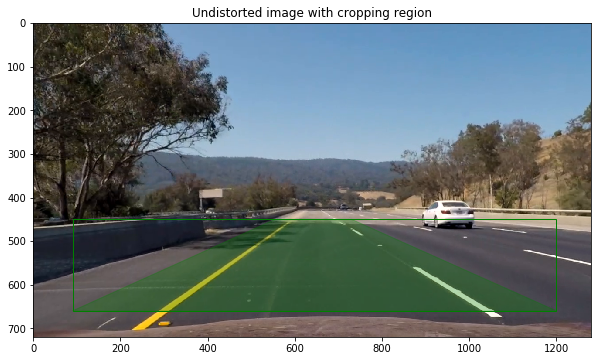

In [14]:
bbox_c1, bbox_r1 = np.min(verticesX), np.min(verticesY)
bbox_c2, bbox_r2 = np.max(verticesX), np.max(verticesY)

b = Rectangle((bbox_c1, bbox_r1),
              bbox_c2-bbox_c1,
              bbox_r2-bbox_r1,
              fill=False,color='g',alpha=1.0) 
roi=Polygon(vertices[0,:,:],closed=True,color='g',alpha=0.3)

f=NewFigure(10,6)
ax=DisplaySub(f,1,1,1,undist,
              title='Undistorted image with cropping region',
              axis='on',cmap='gray')
ax.add_patch(roi)
ax.add_patch(b)
plt.show()

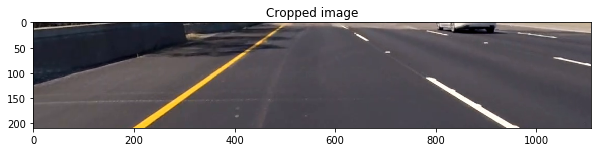

In [15]:
image_crop=undist[bbox_r1:bbox_r2, bbox_c1:bbox_c2]

f=NewFigure(10,6)
ax=DisplaySub(f,1,1,1,image_crop,
              title='Cropped image',axis='on')

### Output of segmentation for cropped image

Elapsed time = 0.006328 sec
Elapsed time = 0.006122 sec


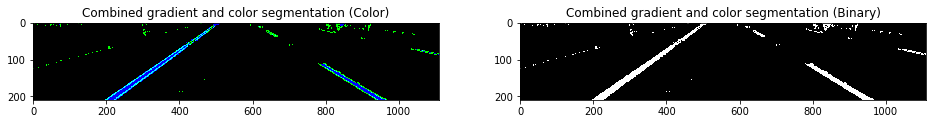

In [16]:
last_time = time.time()
gradx = abs_sobel_thresh(image_crop, orient='x', 
                         sobel_kernel=3, 
                         thresh=(sobelx_thresh, 255))
timeElapsed=time.time()-last_time
print("Elapsed time = %.6f sec"%(timeElapsed))

last_time = time.time()
saturation = color_thresh(image_crop,
                          hthresh=(0, hue_thresh), 
                          sthresh=(saturation_thresh, 255))
timeElapsed=time.time()-last_time
print("Elapsed time = %.6f sec"%(timeElapsed))

combined_color = np.dstack(( np.zeros_like(gradx), 
                            gradx, 
                            saturation)) * 255
combined_binary = np.zeros_like(gradx)
combined_binary[((gradx == 1) | (saturation == 1))] = 1

f=NewFigure(16,12)
ax1=DisplaySub(f,1,2,1,combined_color,
               title='Combined gradient and color segmentation (Color)',
               axis='on')
ax2=DisplaySub(f,1,2,2,combined_binary,
               title='Combined gradient and color segmentation (Binary)',
               axis='on',cmap='gray')

**Note: The processing time is approximately 5 times lesser when processing only the cropped region.**

### Masking of unwanted region

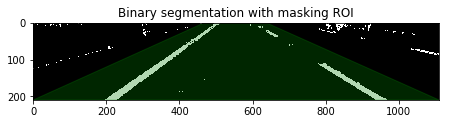

In [17]:
verticesX_cropped=verticesX-bbox_c1
verticesY_cropped=verticesY-bbox_r1
vertices_cropped=np.zeros((1,len(verticesX_cropped),2), 
                          dtype=np.int32)
for i in range(len(verticesX)):
    vertices_cropped[0,i,0]=verticesX_cropped[i]
    vertices_cropped[0,i,1]=verticesY_cropped[i]
roi_cropped=Polygon(vertices_cropped[0,:,:],
                    closed=True,
                    color='g',
                    alpha=0.3)
f=NewFigure(16,12)
ax=DisplaySub(f,1,2,1,combined_binary,
              title='Binary segmentation with masking ROI',
              axis='on',cmap='gray')
ax.add_patch(roi_cropped)
plt.show()

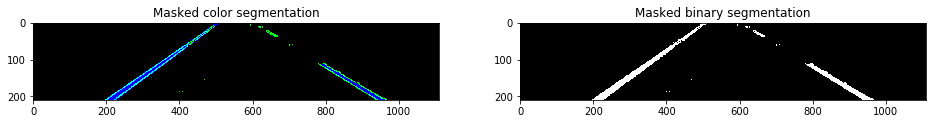

In [18]:
maskedBinary=region_of_interest(combined_binary, 
                                vertices_cropped)
maskedColor=region_of_interest(combined_color, 
                               vertices_cropped)
f=NewFigure(16,12)
ax=DisplaySub(f,1,2,1,maskedColor,
              title='Masked color segmentation',
              axis='on')
ax=DisplaySub(f,1,2,2,maskedBinary,
              title='Masked binary segmentation',
              axis='on',cmap='gray')
plt.show()

### Restore cropped segmentation to original image coordinates

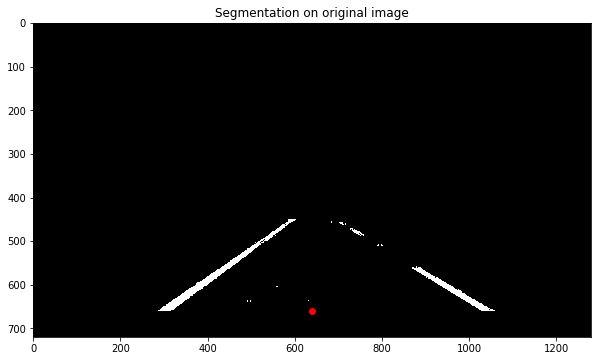

In [19]:
final_segmentation=np.zeros((img_size[1],img_size[0]))
final_segmentation[bbox_r1:bbox_r2, bbox_c1:bbox_c2]=maskedBinary
f=NewFigure(10,12)
ax=DisplaySub(f,1,1,1,final_segmentation,
              title='Segmentation on original image',
              axis='on',
              cmap='gray')
ax.plot(img_size[0]/2,vertices[:,0,1],'bo',color='r')
plt.show()

### Perspective warping

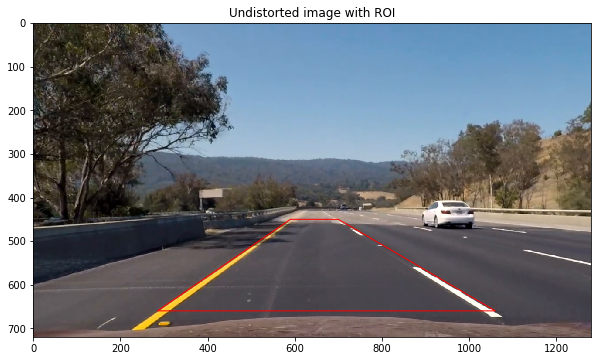

In [20]:
src_X=[285,590,700,1060]
src_Y=[660,450,450,660]
warp_vertices=np.zeros((1,len(src_X),2), dtype=np.int32)
for i in range(len(src_X)):
    warp_vertices[0,i,0]=src_X[i]
    warp_vertices[0,i,1]=src_Y[i]
    
warp_roi=Polygon(warp_vertices[0,:,:],
                 closed=True,
                 fill=False,
                 color='r')
f=NewFigure(10,12)
ax=DisplaySub(f,1,1,1,undist,
              title='Undistorted image with ROI',
              axis='on')
ax.add_patch(warp_roi)
plt.show()

Warped car center point: (173.29, 640.00)


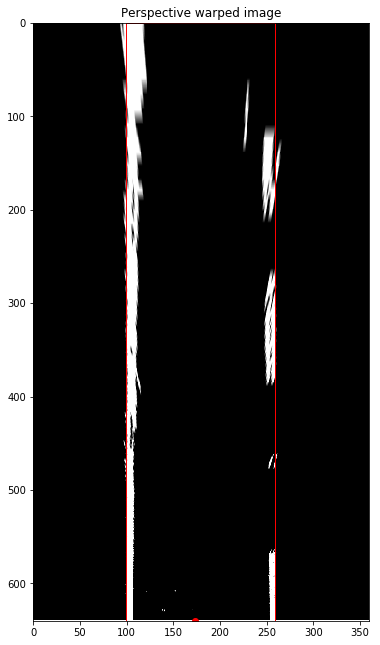

In [21]:
src = np.float32([warp_vertices[:,1,:], 
                  warp_vertices[:,2,:], 
                  warp_vertices[:,3,:], 
                  warp_vertices[:,0,:]])
new_img_size=(360,640)   #(width,height)
offset_y=0
offset_x=100
dst = np.float32([[offset_x, offset_y], 
                  [new_img_size[0]-offset_x, offset_y], 
                  [new_img_size[0]-offset_x, new_img_size[1]-offset_y], 
                  [offset_x, new_img_size[1]-offset_y]])
M = cv2.getPerspectiveTransform(src,dst)
MInv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(final_segmentation, M, 
                             new_img_size, 
                             flags=cv2.INTER_LINEAR)

trans_center=np.matmul(M,[img_size[0]/2,vertices[:,0,1],1])
trans_center=trans_center/trans_center[2]
print('Warped car center point: (%.2f, %.2f)'
      %(trans_center[0],trans_center[1]))

trans=np.array([src_X,src_Y])
trans_mat=np.concatenate((trans,np.ones((1,4),dtype=np.int32)),
                         axis=0)
transformed = np.matmul(M,trans_mat)
transformed=transformed/transformed[2,:]
transformed=transformed.astype(np.int32)
vertices_roi=transformed[:2,:].T.reshape((-1,2))
roi_trans=Polygon(vertices_roi,closed=True,
                  fill=False,color='r')

f=NewFigure(14,11)
ax=DisplaySub(f,1,1,1,warped,
              title='Perspective warped image',
              axis='on',
              cmap='gray')
ax.plot(trans_center[0],trans_center[1],'bo',color='r')
ax.set_xlim(0,new_img_size[0])
ax.set_ylim(new_img_size[1],0)
ax.add_patch(roi_trans)
plt.show()

### Segmentation enhancement - Closing morphology

**Since we used x-axis absolute gradient in the lane line segmentation, there are cases where we obtain two vertical edges instead of a rectangular blob for a lane segment. 7x7 closing morphology operation is used to join the gap between two edges.**

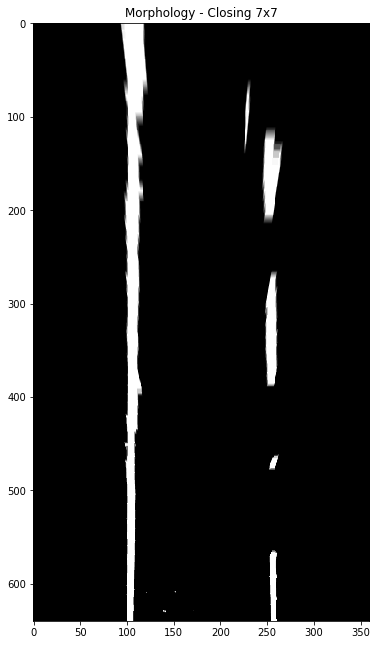

In [22]:
kernel = np.ones((closing_kernel,closing_kernel),np.uint8)
closing = cv2.morphologyEx(warped, cv2.MORPH_CLOSE, kernel)
f=NewFigure(14,11)
ax=DisplaySub(f,1,1,1,closing,
              title='Morphology - Closing %dx%d'
              %(closing_kernel,closing_kernel),
              axis='on',cmap='gray')

### Contour processing

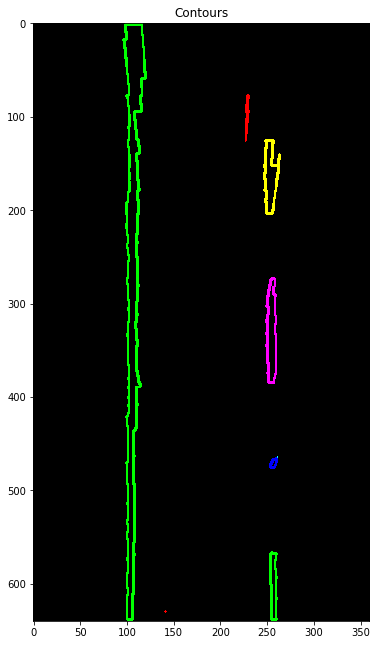

In [23]:
colors=[[255,0,0],[0,255,0],
        [0,0,255],[0,255,255],
        [255,0,255],[255,255,0]]

_, contours, hierarchy = cv2.findContours(closing.astype(np.uint8),
                                          cv2.RETR_LIST,
                                          cv2.CHAIN_APPROX_NONE)
bin_im=np.zeros_like(closing,dtype=np.uint8)
disp=np.dstack((bin_im,bin_im,bin_im))
color_idx=0
for i in range(len(contours)):
    ret=cv2.drawContours(disp, contours, i, 
                         colors[color_idx%len(colors)], 2)
    color_idx+=1

f=NewFigure(14,11)
ax=DisplaySub(f,1,1,1,disp,title='Contours',
              axis='on',cmap='gray')

### Contour filtering - Area

In [24]:
cont_sizes=[cv2.contourArea(c) for c in contours]
print('Contour size: ', str(cont_sizes))
print()
idx=np.argwhere(np.array(cont_sizes)>min_area)
idx=idx.reshape(-1).astype(np.int32).tolist()
cont_sizes_filtered=[cont_sizes[k] for k in idx]
print('Filtered contour size: ', str(cont_sizes_filtered))

Contour size:  [0.0, 382.5, 41.5, 0.0, 859.5, 719.5, 16.5, 6085.5]

Filtered contour size:  [382.5, 41.5, 859.5, 719.5, 6085.5]


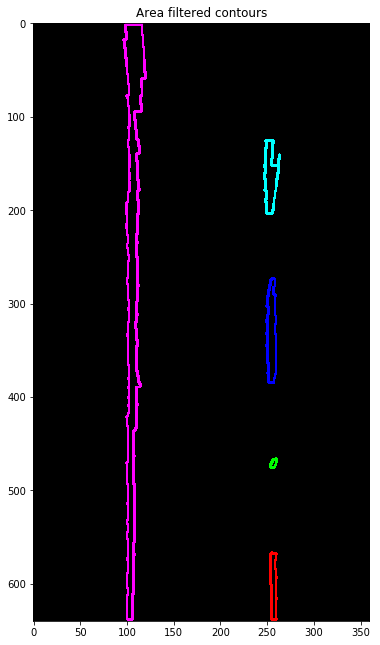

In [25]:
bin_im1=np.zeros_like(closing,dtype=np.uint8)
disp1=np.dstack((bin_im1,bin_im1,bin_im1))
color_idx=0
cont_filtered=[]
for i in idx:
    cont_filtered.append(contours[i])
    ret=cv2.drawContours(disp1, contours, i, 
                         colors[color_idx%len(colors)], 2)
    color_idx+=1

f=NewFigure(14,11)
ax=DisplaySub(f,1,1,1,disp1,
              title='Area filtered contours',
              axis='on')

### Contour filtering - Elongation

In [26]:
cont_elongation=[cv2.fitEllipse(c)[1][1]/cv2.fitEllipse(c)[1][0] 
                 for c in cont_filtered]
print('Contour elongation: ', str(cont_elongation))
print()
idx=np.argwhere(np.array(cont_elongation)>min_elongation)
idx=idx.reshape(-1).astype(np.int32).tolist()
cont_elongation_filtered=[cont_elongation[k] for k in idx]
print('Filtered contour elongation: ', 
      str(cont_elongation_filtered))

Contour elongation:  [17.692472468581087, 1.8695653406598758, 13.682501801875565, 5.1702339615339845, 43.863752710833474]

Filtered contour elongation:  [17.692472468581087, 13.682501801875565, 5.1702339615339845, 43.863752710833474]


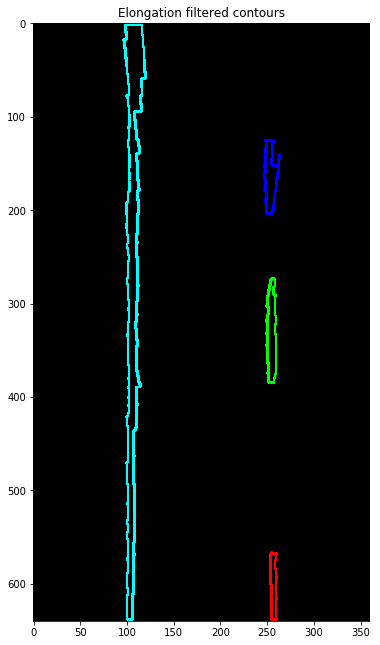

In [27]:
bin_im2=np.zeros_like(closing, dtype=np.uint8)
disp2=np.dstack((bin_im2,bin_im2,bin_im2))
color_idx=0
cont_filtered2=[]
for i in idx:
    cont_filtered2.append(cont_filtered[i])
    ret=cv2.drawContours(disp2, cont_filtered, i, 
                         colors[color_idx%len(colors)], 2)
    color_idx+=1

f=NewFigure(14,11)
ax=DisplaySub(f,1,1,1,disp2,
              title='Elongation filtered contours',
              axis='on')

### Contour filtering - Minor length

In [28]:
cont_minorlength=[np.min(cv2.minAreaRect(c)[1]) 
                  for c in cont_filtered2]
print('Contour minor length: ', str(cont_minorlength))
print()
idx=np.argwhere(np.array(cont_minorlength)>min_minorlength)
idx=idx.reshape(-1).astype(np.int32).tolist()
cont_minorlength_filtered=[cont_minorlength[k] for k in idx]
print('Filtered contour minor length: ', 
      str(cont_minorlength_filtered))

Contour minor length:  [7.0, 10.0, 15.729955673217773, 23.774063110351562]

Filtered contour minor length:  [7.0, 10.0, 15.729955673217773, 23.774063110351562]


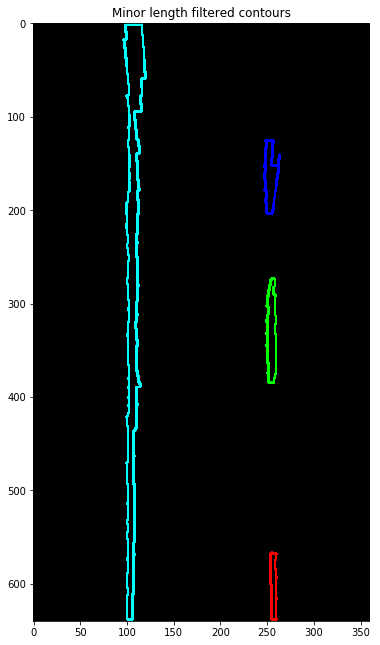

In [29]:
bin_im3=np.zeros_like(closing, dtype=np.uint8)
disp3=np.dstack((bin_im3,bin_im3,bin_im3))
color_idx=0
cont_filtered3=[]
for i in idx:
    cont_filtered3.append(cont_filtered2[i])
    ret=cv2.drawContours(disp3, cont_filtered2, i, 
                         colors[color_idx%len(colors)], 2)
    color_idx+=1

f=NewFigure(14,11)
ax=DisplaySub(f,1,1,1,disp3,
              title='Minor length filtered contours',
              axis='on')

### Segmentation function

In [30]:
def segment_function(image, vertices, M, 
                     sobel_kernel=3,sx_thresh=(0,255),
                     ch_thresh=(0,255),cs_thresh=(0,255),
                     closing_kernel=5,min_area=50,
                     min_elongation=2.0,
                     min_minorlength=4.0,
                     new_img_size=(360,640)):
    img_size=image.shape[1::-1]
    
    # cropping image
    verticesX=vertices[:,:,0].reshape(-1).tolist()
    verticesY=vertices[:,:,1].reshape(-1).tolist()
    bbox_c1, bbox_r1 = np.min(verticesX), np.min(verticesY)
    bbox_c2, bbox_r2 = np.max(verticesX), np.max(verticesY)
    
    verticesX_cropped=verticesX-bbox_c1
    verticesY_cropped=verticesY-bbox_r1
    vertices_cropped=np.zeros((1,len(verticesX_cropped),2), 
                              dtype=np.int32)
    for i in range(len(verticesX)):
        vertices_cropped[0,i,0]=verticesX_cropped[i]
        vertices_cropped[0,i,1]=verticesY_cropped[i]
        
    image_crop=image[bbox_r1:bbox_r2, bbox_c1:bbox_c2]
    
    # x gradient threshold
    gradx = abs_sobel_thresh(image_crop, orient='x', 
                             sobel_kernel=sobel_kernel, 
                             thresh=sx_thresh)
    # saturation threshold
    saturation = color_thresh(image_crop,
                              sthresh=cs_thresh,
                              hthresh=ch_thresh)
    # combined
    combined_binary = np.zeros_like(gradx)
    combined_binary[((gradx == 1) | (saturation == 1))] = 1
    # masking
    masked=region_of_interest(combined_binary, 
                              vertices_cropped)
    
    segmentation=np.zeros((img_size[1],img_size[0]))
    segmentation[bbox_r1:bbox_r2, bbox_c1:bbox_c2]=masked

    warped = cv2.warpPerspective(segmentation, M, 
                                 new_img_size, 
                                 flags=cv2.INTER_LINEAR)
    
    # closing morphology
    kernel = np.ones((closing_kernel,closing_kernel))
    closing = cv2.morphologyEx(warped, cv2.MORPH_CLOSE, kernel)
    # contour processing
    _, contours, hierarchy = cv2.findContours(closing.astype(np.uint8),
                                              cv2.RETR_LIST,
                                              cv2.CHAIN_APPROX_NONE)
    
    cont_sizes=[cv2.contourArea(c) for c in contours]
    idx=np.argwhere(np.array(cont_sizes)>min_area)
    idx=idx.reshape(-1).astype(np.int32).tolist()
    cont_filtered=[]
    for i in idx:
        cont_filtered.append(contours[i])

    cont_elongation=[cv2.fitEllipse(c)[1][1]/cv2.fitEllipse(c)[1][0] 
                     for c in cont_filtered]
    idx=np.argwhere(np.array(cont_elongation)>min_elongation)
    idx=idx.reshape(-1).astype(np.int32).tolist()
    cont_filtered2=[]
    for i in idx:
        cont_filtered2.append(cont_filtered[i])
        
    cont_minorlength=[np.min(cv2.minAreaRect(c)[1]) 
                      for c in cont_filtered2]
    idx=np.argwhere(np.array(cont_minorlength)>min_minorlength)
    idx=idx.reshape(-1).astype(np.int32).tolist()
    filtered_label=np.zeros_like(closing,dtype=np.uint8)
    for i in idx:
        ret=cv2.drawContours(filtered_label, cont_filtered2, 
                             i, 255, 2)
    
    return filtered_label

Elapsed time = 0.054472 sec


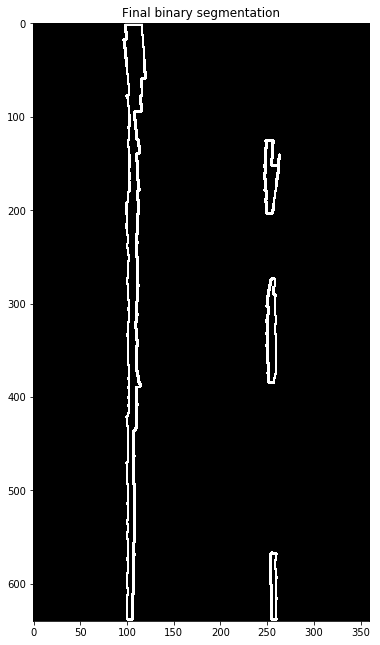

In [31]:
last_time = time.time()
undist = cv2.undistort(image, mtx, dist)
final=segment_function(undist, vertices, M, 
                       sobel_kernel=sobel_kernel, 
                       sx_thresh=(sobelx_thresh, 255),
                       ch_thresh=(0, hue_thresh), 
                       cs_thresh=(saturation_thresh, 255), 
                       closing_kernel=closing_kernel,
                       min_area=min_area,
                       min_elongation=min_elongation,
                       min_minorlength=min_minorlength)
timeElapsed=time.time()-last_time
print("Elapsed time = %.6f sec"%(timeElapsed))
f=NewFigure(14,11)
ax=DisplaySub(f,1,2,1,final,
              title='Final binary segmentation',
              axis='on',cmap='gray')
plt.show()

### Lane line clustering (Left and right lane)

**Histogram of bottom half of the contour image is used to determine starting point of left and right lane.**

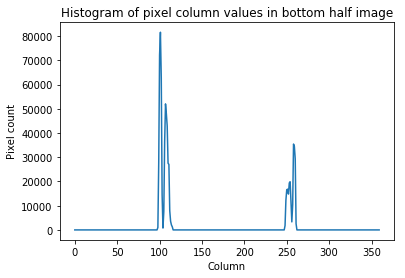

In [32]:
histogram = np.sum(final[int(final.shape[0]/2):,:], axis=0)
plt.plot(range(histogram.shape[0]),histogram)
plt.xlabel('Column')
plt.ylabel('Pixel count')
plt.title('Histogram of pixel column values in bottom half image')
plt.show()

**Due to contours are hollow inside, there are discontinuities in the peaks of the histogram. 1D kernel of size 30 is used to smooth the histogram.**

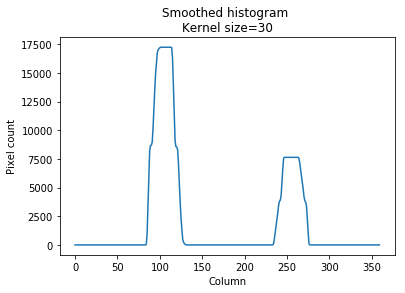

In [33]:
histogram = np.sum(final[int(final.shape[0]/2):,:], axis=0)
smooth_kernel=30
m=np.ones((smooth_kernel))/float(smooth_kernel)
histogram_smoothed = np.convolve( m[::-1], histogram, mode='same')
plt.plot(range(histogram_smoothed.shape[0]),histogram_smoothed)
plt.xlabel('Column')
plt.ylabel('Pixel count')
plt.title('Smoothed histogram \nKernel size=%d'
          %(smooth_kernel))
plt.show()

**Blind search for lane contour pixels and fitting of lane lines**

In [34]:
def fit_line_init(image, nwindows = 9, 
                  smooth_kernel=30, 
                  margin = 50, 
                  minpixwindow = 5, 
                  minpixlane = 20, 
                  gen_viz=False):
    # nwindows - the number of sliding windows
    # margin - the width of the windows +/- margin
    # minpix - minimum number of pixels found to recenter window
    
    if (gen_viz==True):
        out_img = np.dstack((image, image, image))*255
        out_img = out_img.astype(np.uint8)
    else:
        out_img = None
    histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
    m=np.ones((smooth_kernel))/float(smooth_kernel)
    histogram_smoothed = np.convolve( m[::-1], histogram, 
                                     mode='valid')
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if (gen_viz==True):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,
                          (win_xleft_low,win_y_low),
                          (win_xleft_high,win_y_high),
                          (0,255,0), 2) 
            cv2.rectangle(out_img,
                          (win_xright_low,win_y_low),
                          (win_xright_high,win_y_high),
                          (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on 
        # their mean position
        if len(good_left_inds) > minpixwindow:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpixwindow:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if (leftx.shape[0]>minpixlane):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
    if (rightx.shape[0]>minpixlane):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
    
    return out_img, left_fit, right_fit, leftx, lefty, rightx, righty

In [35]:
last_time=time.time()

(_, \
 left_fit, \
 right_fit, \
 left_allx, \
 left_ally, \
 right_allx, \
 right_ally)= fit_line_init(final, gen_viz=False)

timeElapsed=time.time()-last_time
print("Elapsed time = %.6f sec"%(timeElapsed))

Elapsed time = 0.003900 sec


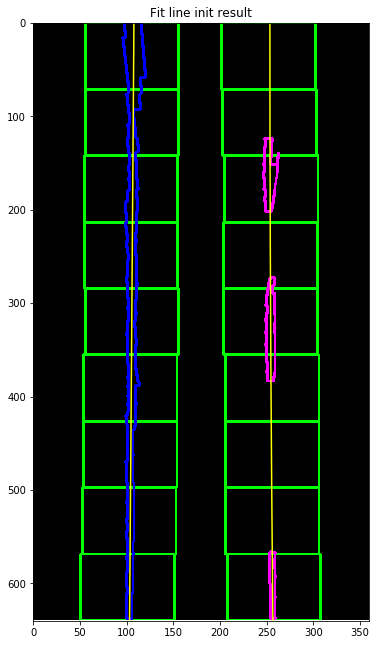

In [36]:
(out_img, \
 left_fit, \
 right_fit, \
 left_allx, \
 left_ally, \
 right_allx, \
 right_ally)= fit_line_init(final, gen_viz=True)

# Generate x and y values for plotting
ploty = np.linspace(0, final.shape[0]-1, final.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[left_ally, left_allx] = [0, 0, 255]
out_img[right_ally, right_allx] = [255, 0, 255]
f=NewFigure(14,11)
ax=DisplaySub(f,1,1,1,out_img,title='Fit line init result',axis='on')
ax.plot(left_fitx, ploty, color='yellow')
ax.plot(right_fitx, ploty, color='yellow')
ax.set_xlim(0, new_img_size[0])
ax.set_ylim(new_img_size[1], 0)
plt.show()

**If lane lines are found in one frame, there is no need to execute the blind search again in the next frame. Margin of 50 pixels is used along the fitted lines for selection of lane contour pixels.**

In [37]:
def fit_line_next(image, left_fit, right_fit, 
                  margin = 50, minpixlane = 20):
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + 
                                   left_fit[1]*nonzeroy + 
                                   left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                                   left_fit[1]*nonzeroy + 
                                   left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + 
                                    right_fit[1]*nonzeroy + 
                                    right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                                    right_fit[1]*nonzeroy + 
                                    right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if (leftx.shape[0]>minpixlane):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
    if (rightx.shape[0]>minpixlane):
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

last_time=time.time()

(left_fit, \
 right_fit, \
 left_allx, \
 left_ally, \
 right_allx, \
 right_ally)= fit_line_next(final, left_fit, right_fit)

timeElapsed=time.time()-last_time
print("Elapsed time = %.6f sec"%(timeElapsed))

Elapsed time = 0.002697 sec


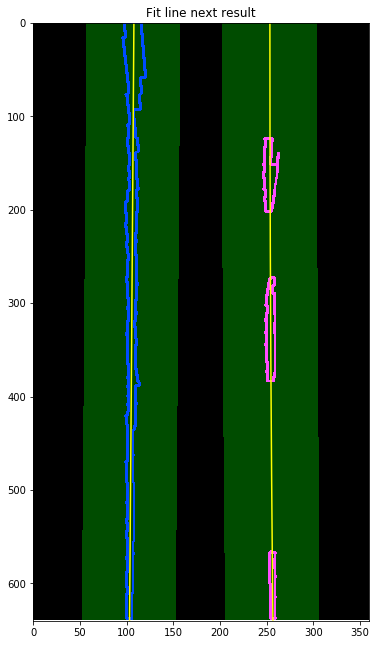

In [38]:
# Generate x and y values for plotting
ploty = np.linspace(0, final.shape[0]-1, final.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((final, final, final))*255
out_img = out_img.astype(np.uint8)
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[left_ally, left_allx] = [0, 0, 255]
out_img[right_ally, right_allx] = [255, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 50
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

f=NewFigure(14,11)
ax=DisplaySub(f,1,1,1,result,title='Fit line next result',axis='on')
ax.plot(left_fitx, ploty, color='yellow')
ax.plot(right_fitx, ploty, color='yellow')
ax.set_xlim(0, new_img_size[0])
ax.set_ylim(new_img_size[1], 0)
plt.show()

### Curvature radius calculation

$R_{curve}=\frac{\left [1+f'(y)^{2})  \right ]^{\frac{2}{3}}}{\left | f''(y) \right |}$

$f(y)=Ay^{2}+By+C$

$f'(y)=2Ay+B$

$f''(y)=2A$

$R_{curve}=\frac{\left [1+(2Ay+B)^{2})  \right ]^{\frac{2}{3}}}{\left | 2A \right |}$

In [39]:
y_eval = trans_center[1]

left_curverad_num = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5)
left_curverad_denom = np.absolute(2*left_fit[0])
left_curverad = left_curverad_num / left_curverad_denom

right_curverad_num = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5)
right_curverad_denom = np.absolute(2*right_fit[0])
right_curverad =  right_curverad_num / right_curverad_denom

print('Left lane curvature radius: %.2f pixel' %(left_curverad))
print('Right lane curvature radius: %.2f pixel' %(right_curverad))

Left lane curvature radius: 594455.04 pixel
Right lane curvature radius: 62057.50 pixel


**To obtain meaningful measurement, scale factor x and y axis for the warped image are determined. The fitted lane lines are converted to meters and new curve parameters are fitted in metric coordinates.**

**The curvature radius in meters is then recalculated using these new curve parameters.**

In [40]:
# Define conversions in x and y from pixels space to meters
left_base_pix = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
right_base_pix = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
lane_width_pix = right_base_pix - left_base_pix
lane_height_pix = new_img_size[1]

ym_per_pix = 30/lane_height_pix# meters per pixel in y dimension
xm_per_pix = 3.7/lane_width_pix # meters per pixel in x dimension

print('Lane width in pixel: %.2f' %(lane_width_pix))
print('Lane height in pixel: %.2f' %(lane_height_pix))
print('Conversion factor in x axis: %.3f m/pixel' %(xm_per_pix))
print('Conversion factor in y axis: %.3f m/pixel' %(ym_per_pix))
print()

# Calculate the new radii of curvature
leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

y_eval_m = y_eval*ym_per_pix
left_curverad_metric = ((1 + (2*left_fit_cr[0]*y_eval_m + left_fit_cr[1])**2)**1.5) \
                        / np.absolute(2*left_fit_cr[0])
right_curverad_metric = ((1 + (2*right_fit_cr[0]*y_eval_m + right_fit_cr[1])**2)**1.5) \
                        / np.absolute(2*right_fit_cr[0])
average_curverad_metric = (left_curverad_metric+right_curverad_metric)/2
# Now our radius of curvature is in meters
print('Left lane curvature radius: %.2f m' %(left_curverad_metric))
print('Right lane curvature radius: %.2f m' %(right_curverad_metric))
print('Average lane curvature radius: %.2f m' 
      %(average_curverad_metric))

Lane width in pixel: 153.44
Lane height in pixel: 640.00
Conversion factor in x axis: 0.024 m/pixel
Conversion factor in y axis: 0.047 m/pixel

Left lane curvature radius: 54163.65 m
Right lane curvature radius: 5654.09 m
Average lane curvature radius: 29908.87 m


### Vehicle center offset from lane center

In [41]:
lane_halfwidth = (right_fitx[new_img_size[1]-1] - 
                  left_fitx[new_img_size[1]-1]) / 2
lane_center_x =  left_fitx[new_img_size[1]-1] + lane_halfwidth
lane_offset_x = (trans_center[0]-lane_center_x)*xm_per_pix

print('Offset from lane center: %.2f m'%(lane_offset_x))

Offset from lane center: -0.16 m


### Result visualization

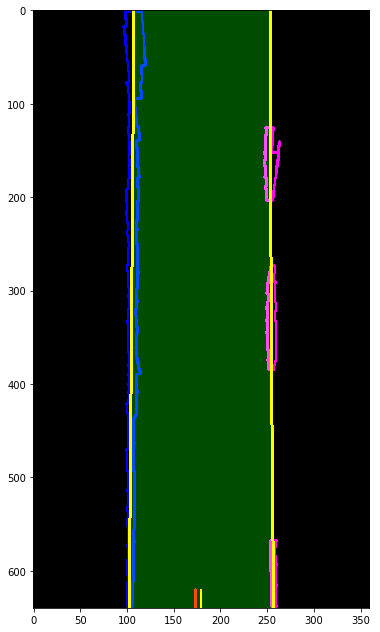

In [42]:
marker_height = 20
marker_width = 2
line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
line_pts = np.hstack((line_window1, line_window2))

out_img = np.dstack((final, final, final))*255
out_img = out_img.astype(np.uint8)
out_img[left_ally, left_allx] = [0, 0, 255]
out_img[right_ally, right_allx] = [255, 0, 255]

left_contour = np.array((left_fitx, ploty)).T
left_contour = left_contour.reshape((-1,1,2)).astype(np.int32)
cv2.drawContours(out_img,left_contour,-1,(255,255,0),2)
right_contour = np.array((right_fitx, ploty)).T
right_contour = right_contour.reshape((-1,1,2)).astype(np.int32)
cv2.drawContours(out_img,right_contour,-1,(255,255,0),2)

cv2.line(out_img,
         (int(lane_center_x), int(trans_center[1])),
         (int(lane_center_x), int(trans_center[1])-marker_height),
         (255,255,0),
         marker_width)
cv2.line(out_img,
         (int(trans_center[0]),int(trans_center[1])),
         (int(trans_center[0]),int(trans_center[1])-marker_height),
         (255,0,0),
         marker_width)
window_img = np.zeros_like(out_img)
cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

f=NewFigure(14,11)
ax=DisplaySub(f,1,1,1,result,title='',axis='on')
plt.show()

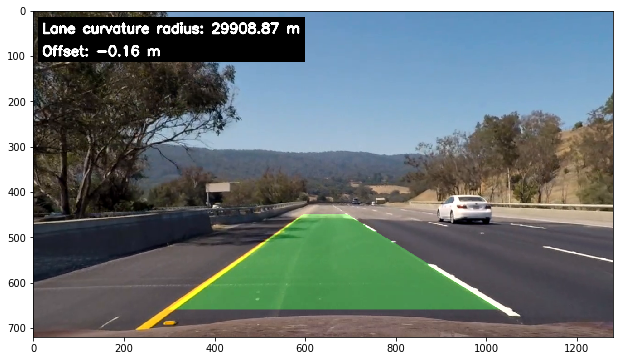

In [43]:
font = cv2.FONT_HERSHEY_SIMPLEX

lane_unwarped = cv2.warpPerspective(window_img, MInv, 
                                    img_size, 
                                    flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(undist, 1, lane_unwarped, 0.3, 0)

result[15:115,10:600,:]=0
ret=cv2.putText(result,
                'Lane curvature radius: %.2f m' %(average_curverad_metric),
                (20,50), font, 
                1, (255,255,255),
                4,cv2.LINE_AA)
ret=cv2.putText(result,
                'Offset: %.2f m'%(lane_offset_x),
                (20,100), font, 
                1,(255,255,255),
                4,cv2.LINE_AA)

f=NewFigure()
ax=DisplaySub(f,1,1,1,result,axis='on')

### Full pipeline

**A customized Line object is created to store line related characteristics for last n iterations.**

In [44]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n=5):
        self.iter = 0
        #n iterations to keep
        self.n = n
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque()
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

**Iterative reweighted least squares (IRLS) is used for fitting of lane curve with outlier removal.**

In [45]:
def IRLS(A,b,algorithm='tukey',clip_factor=2,iteration=5):
    '''
    Iterative reweighted least squares fitting.
    Available algorithms:
        Huber - Impact of outliers is decreased based on Huber's weight function. 
        Tukey - Outliers are ignored based on Tukey's weight function.
    Reference:
        P. J. Huber – Robust Statistics. John Wiley & Sons, New York (1981).
        F. Mosteller, J. W. Tukey – Data Analysis and Regression. 
                                    Addison-Wesley, Reading, MA (1977).
    '''
    w = np.repeat(1.,b.shape[0])
    W = np.diag(w)
    WA = np.matmul(W,A)
    WB = np.matmul(W,b)
    theta=np.linalg.lstsq(WA,WB)

    for k in range(iteration):
        fit=np.matmul(A,theta[0])
        d=fit-b
        ad=np.abs(d)
        mad=np.median(ad)
        std=mad/0.6745
        
        if (algorithm=='huber'):
            w = np.repeat(1.,b.shape[0])
            ids=np.argwhere(ad>(clip_factor*std))
            ids=ids[:,0].reshape(-1).tolist()
            
            for i in ids:
                w[i]=(clip_factor*std) / ad[i]
                
        if (algorithm=='tukey'):
            w = np.repeat(0.,b.shape[0])
            ids=np.argwhere(ad<=(clip_factor*std))
            ids=ids[:,0].reshape(-1).tolist()
            
            for i in ids:
                w[i]=(1-(d[i]/(clip_factor*std))**2)**2
              
        W = np.diag(w)
        WA = np.matmul(W,A)
        WB = np.matmul(W,b)
        theta=np.linalg.lstsq(WA,WB)
    return theta[0]

**Full lane detection pipeline function.**

In [46]:
def process_image(im):
    undist = cv2.undistort(im, mtx, dist)
    warped=segment_function(undist, vertices, M, 
                            sobel_kernel=sobel_kernel, 
                            sx_thresh=(sobelx_thresh, 255),
                            ch_thresh=(0, hue_thresh), 
                            cs_thresh=(saturation_thresh, 255), 
                            closing_kernel=closing_kernel,
                            min_area=min_area,
                            min_elongation=min_elongation,
                            min_minorlength=min_minorlength)
    warped=warped.astype(np.uint8)
    
    if (lineLeft.detected and lineRight.detected):
        (left_fit, \
         right_fit, \
         left_allx, \
         left_ally, \
         right_allx, \
         right_ally)= fit_line_next(warped, 
                                    lineLeft.best_fit.reshape((-1)), 
                                    lineRight.best_fit.reshape((-1)))
    else:
        (_, \
         left_fit, \
         right_fit, \
         left_allx, \
         left_ally, \
         right_allx, \
         right_ally)= fit_line_init(warped, gen_viz=False)
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    
    ## LEFT LANE LINE SMOOTHING
    # Concatenate fitted line points for last n iterations
    lineLeft.iter += 1
    if (left_fit!= None):
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        
        lineLeft.detected = True
        lineLeft.current_fit = left_fit
        lineLeft.allx = left_allx
        lineLeft.ally = left_ally
        lineLeft.recent_xfitted.append(left_fitx)
    else:
        lineLeft.detected = False
        lineLeft.current_fit = None
        lineLeft.allx = None
        lineLeft.ally = None
        lineLeft.recent_xfitted.append(np.array([0]))
    if (lineLeft.iter >= lineLeft.n+1):
        lineLeft.recent_xfitted.popleft()
        
    # Select valid entries of last n fitted lines
    lengthLeft=[]
    for i in range(len(lineLeft.recent_xfitted)):
        lengthLeft.append(lineLeft.recent_xfitted[i].shape[0])
    idxLeft=np.argwhere(np.array(lengthLeft)!=1).reshape(-1).tolist()
    left_recent_xfitted_valid = [lineLeft.recent_xfitted[k] for k in idxLeft]
        
    # Fit with IRLS
    if (len(idxLeft)!=0):
        tmp=np.array(left_recent_xfitted_valid)
        tmp_idx=[k for k in range(0,tmp.shape[1],25)]
        tmp_ploty=ploty[tmp_idx]
        x_=np.reshape(tmp[:,tmp_idx],(-1,1))
        y_=np.reshape(matlib.repmat(tmp_ploty,1,len(idxLeft)),(-1,1))
        A=np.concatenate((y_**2,y_,np.ones((y_.shape[0],1))),axis=1)
        b=x_
        lineLeft.best_fit=IRLS(A,b)
        
        left_bestfitx = lineLeft.best_fit[0]*ploty**2 + \
                        lineLeft.best_fit[1]*ploty + \
                        lineLeft.best_fit[2]
    else:
        # if no valid entry for last n iteration, return empty result 
        return im

    ## RIGHT LANE LINE SMOOTHING
    # Concatenate fitted line points for last n iterations
    lineRight.iter += 1
    if (right_fit!= None):
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        lineRight.detected = True
        lineRight.current_fit = right_fit
        lineRight.allx = right_allx
        lineRight.ally = right_ally
        lineRight.recent_xfitted.append(right_fitx)
    else:
        lineRight.detected = False
        lineRight.current_fit = None
        lineRight.allx = None
        lineRight.ally = None
        lineRight.recent_xfitted.append(np.array([0]))
    if (lineRight.iter >= lineRight.n+1):
        lineRight.recent_xfitted.popleft()
    
    # Select valid entries of last n fitted lines
    lengthRight=[]
    for i in range(len(lineRight.recent_xfitted)):
        lengthRight.append(lineRight.recent_xfitted[i].shape[0])
    idxRight=np.argwhere(np.array(lengthRight)!=1).reshape(-1).tolist()
    right_recent_xfitted_valid = [lineRight.recent_xfitted[k] for k in idxRight]
        
    # Fit with IRLS
    if (len(idxRight)!=0):
        tmp=np.array(right_recent_xfitted_valid)
        tmp_idx=[k for k in range(0,tmp.shape[1],25)]
        tmp_ploty=ploty[tmp_idx]
        x_=np.reshape(tmp[:,tmp_idx],(-1,1))
        y_=np.reshape(matlib.repmat(tmp_ploty,1,len(idxRight)),(-1,1))
        A=np.concatenate((y_**2,y_,np.ones((y_.shape[0],1))),axis=1)
        b=x_
        lineRight.best_fit=IRLS(A,b)
        
        right_bestfitx = lineRight.best_fit[0]*ploty**2 + \
                         lineRight.best_fit[1]*ploty + \
                         lineRight.best_fit[2]
    else:
        # if no valid entry for last n iteration, return empty result 
        return im

    # Generate visualization for warped image
    out_img = np.dstack((warped, warped, warped))*255
    out_img = out_img.astype(np.uint8)
    # Fill left and right lanes' contour pixel with diff colors
    out_img[left_ally, left_allx] = [0, 0, 255]
    out_img[right_ally, right_allx] = [255, 0, 255]
    # Draw fitted lane lines with color yellow
    left_contour = np.array((left_bestfitx, ploty)).T
    left_contour = left_contour.reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(out_img,left_contour,-1,(255,255,0),2)
    right_contour = np.array((right_bestfitx, ploty)).T
    right_contour = right_contour.reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(out_img,right_contour,-1,(255,255,0),2)
    
    # Generate detected lane region in warped image
    line_window1 = np.array([np.transpose(np.vstack([left_bestfitx, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_bestfitx, ploty])))])
    line_pts = np.hstack((line_window1, line_window2))
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    
    # Size for vehicle center and lane center markers
    marker_height = 20
    marker_width = 2
    
    # Calculate vehicle offset from lane center
    lane_halfwidth = (right_bestfitx[new_img_size[1]-1] - 
                      left_bestfitx[new_img_size[1]-1]) / 2
    lane_center_x =  left_bestfitx[new_img_size[1]-1] + lane_halfwidth
    lane_offset_x = (trans_center[0]-lane_center_x)*xm_per_pix

    # Display markers for vehicle center and lane center
    cv2.line(out_img,
             (int(lane_center_x), int(trans_center[1])),
             (int(lane_center_x), int(trans_center[1])-marker_height),
             (255,255,0),
             marker_width)
    cv2.line(out_img,
             (int(trans_center[0]),int(trans_center[1])),
             (int(trans_center[0]),int(trans_center[1])-marker_height),
             (255,0,0),
             marker_width)
    
    # Calculate curvature radius
    y_eval = int(trans_center[1])
    y_eval_m = y_eval*ym_per_pix 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_bestfitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_bestfitx*xm_per_pix, 2)
    left_curverad_metric = ((1 + (2*left_fit_cr[0]*y_eval_m + left_fit_cr[1])**2)**1.5) \
                            / np.absolute(2*left_fit_cr[0])
    right_curverad_metric = ((1 + (2*right_fit_cr[0]*y_eval_m + right_fit_cr[1])**2)**1.5)\
                            / np.absolute(2*right_fit_cr[0])
    curverad_metric = (left_curverad_metric+right_curverad_metric)/2.
    
    # Two modes of output
    if (outMode=='warped'):
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    if (outMode=='final'):
        out_unwarped = cv2.warpPerspective(out_img, MInv, 
                                           img_size, 
                                           flags=cv2.INTER_LINEAR)
        window_unwarped = cv2.warpPerspective(window_img, MInv, 
                                              img_size, 
                                              flags=cv2.INTER_LINEAR)
        result = cv2.addWeighted(undist, 1, window_unwarped, 0.3, 0)

        font = cv2.FONT_HERSHEY_SIMPLEX
        result[15:115,10:600,:]=0
        ret=cv2.putText(result,
                        'Lane curvature radius: %.2f m' %(curverad_metric),
                        (20,50), font, 
                        1,(255,255,255),
                        4,cv2.LINE_AA)
        ret=cv2.putText(result,
                        'Offset: %.2f m'%(lane_offset_x),
                        (20,100), font, 
                        1,(255,255,255),
                        4,cv2.LINE_AA)
    return result

### Create output videos

**Detected lane and vehicle offset from lane center visualized in warped image.**

In [47]:
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip = VideoFileClip('project_video.mp4').subclip(0,5)
clip = VideoFileClip('project_video.mp4')

lineLeft=Line(n=5)
lineRight=Line(n=5)
outMode='warped'
clip_processed_warped = clip.fl_image(process_image)
warpedOutputPath = 'project_video_warped.mp4'
%time clip_processed_warped.write_videofile(warpedOutputPath, audio=False)

[MoviePy] >>>> Building video project_video_warped.mp4
[MoviePy] Writing video project_video_warped.mp4


100%|█████████▉| 1260/1261 [02:15<00:00,  9.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_warped.mp4 

CPU times: user 5min 8s, sys: 10min 23s, total: 15min 32s
Wall time: 2min 15s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(warpedOutputPath))

**Visualization of detected lane augmented on undistorted video frame. The computed lane curvature radius and vehicle offset from lane center in meters are displayed on the upper left of the frame.**

In [49]:
lineLeft=Line(n=5)
lineRight=Line(n=5)
outMode='final'
clip_processed_warped = clip.fl_image(process_image)
finalOutputPath = 'project_video_final.mp4'
%time clip_processed_warped.write_videofile(finalOutputPath, audio=False)

[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


100%|█████████▉| 1260/1261 [02:50<00:00,  7.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

CPU times: user 7min 18s, sys: 9min 30s, total: 16min 48s
Wall time: 2min 50s


In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(finalOutputPath))